# Logistic Regression

Today you will:
1. Implement logistic regression from scratch
2. Use sklearn's optimization algorithms
3. Test on dummy data with visualizations
4. Explore sklearn's LogisticRegression parameters

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
#from sklearn.optimization import minimize
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

plt.style.use('seaborn-v0_8')
np.random.seed(42)

## Part 1: Implementing Logistic Regression from Scratch

### Step 1: Implement the Sigmoid Function
The sigmoid function maps any real number to a value between 0 and 1:
$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

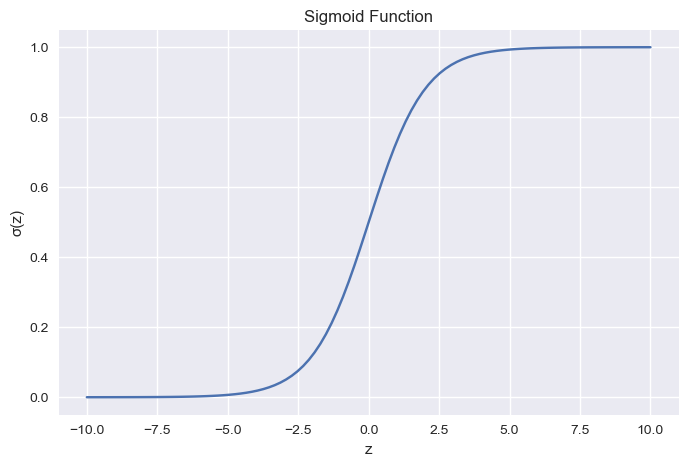

In [5]:
def sigmoid(z):
    """
    Compute the sigmoid function.
    
    Args:
        z: Input values (can be scalar or array)
    
    Returns:
        Sigmoid of z
    """
    # TODO: Implement sigmoid function
    # Hint: Use np.exp() and handle potential overflow
    return 1 / (1 + np.exp(-np.clip(z, -250, 250)))

# Test the sigmoid function
z_test = np.linspace(-10, 10, 100)
plt.figure(figsize=(8, 5))
plt.plot(z_test, sigmoid(z_test))
plt.title('Sigmoid Function')
plt.xlabel('z')
plt.ylabel('σ(z)')
plt.grid(True)
plt.show()

### Step 2: Implement the Logistic Loss Function
The logistic loss (cross-entropy) for binary classification:
$$J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} [y^{(i)} \log(h_\theta(x^{(i)})) + (1-y^{(i)}) \log(1-h_\theta(x^{(i)}))]$$

where $h_\theta(x) = \sigma(\theta^T x)$

In [7]:
def logistic_loss(theta, X, y):
    """
    Compute logistic loss function.
    
    Args:
        theta: Parameters (weights and bias)
        X: Feature matrix (m x n)
        y: Labels (m x 1)
    
    Returns:
        Loss value
    """
    m = len(y)
    
    # TODO: Implement logistic loss
    # Steps:

    # Prevent log(0) by adding small epsilon


    z = X @ theta
    h = 1 / (1 + np.exp(-z))
    epsilon = 1e-15
    h = np.clip(h, epsilon, 1 - epsilon)
    loss = - (1/m) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
    
    return loss

def logistic_gradient(theta, X, y):
    """
    Compute gradient of logistic loss.
    
    Args:
        theta: Parameters
        X: Feature matrix
        y: Labels
    
    Returns:
        Gradient vector
    """
    m = len(y)
    z = X @ theta
    h = 1 / (1 + np.exp(-z))
    error = h - y
    gradient = (X.T @ error) / m

    # TODO: Implement gradient computation
    return gradient

### Step 3: Create Dummy Dataset

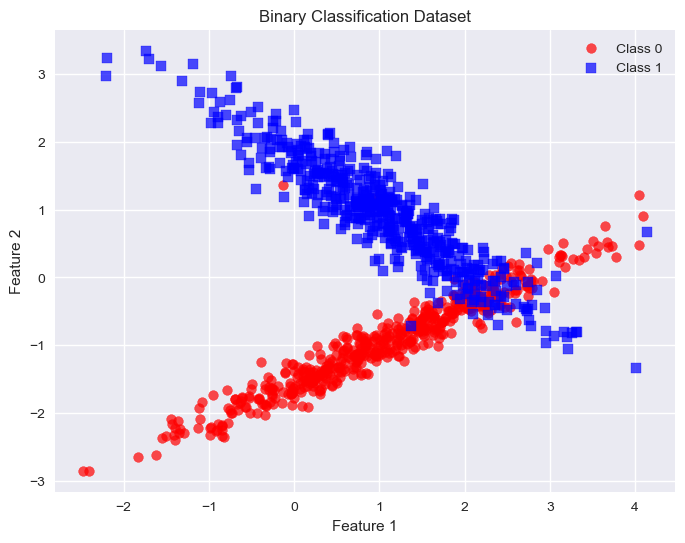

Training set size: 700
Test set size: 300
Number of features (with bias): 3


In [8]:
# Generate dummy binary classification dataset
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, 
                          n_informative=2, n_clusters_per_class=1, 
                          random_state=42)

# Add bias term (intercept)
X_with_bias = np.c_[np.ones(X.shape[0]), X]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_with_bias, y, 
                                                   test_size=0.3, random_state=42)

# Visualize the dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[y==0, 0], X[y==0, 1], c='red', marker='o', alpha=0.7, label='Class 0')
plt.scatter(X[y==1, 0], X[y==1, 1], c='blue', marker='s', alpha=0.7, label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Binary Classification Dataset')
plt.legend()
plt.grid(True)
plt.show()

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Number of features (with bias): {X_train.shape[1]}")

### Step 4: Optimize Using scipy.optimize.minimize
We'll use sklearn's optimization algorithms through scipy's minimize function.

In [17]:
from scipy.optimize import minimize

class LogisticRegressionFromScratch:
    def __init__(self, method='BFGS'):
        self.method = method
        self.theta = None
        self.cost_history = []
    
    def fit(self, X, y):
        # Initialize parameters
        n_features = X.shape[1]
        initial_theta = np.random.normal(0, 0.01, n_features)
        
        # Callback to store cost history
        def callback(theta):
            cost = logistic_loss(theta, X, y)
            self.cost_history.append(cost)
        
        # TODO: Use scipy.optimize.minimize to optimize
        # Try different methods: 'BFGS', 'L-BFGS-B', 'Newton-CG'
        
        result = minimize(
            fun=logistic_loss,
            x0=initial_theta,
            args=(X, y),
            method=self.method,
            jac=logistic_gradient,
            callback=callback,
            options={'maxiter': 1000}
        )
        
        self.theta = result.x
        print(f"Optimization converged: {result.success}")
        print(f"Final cost: {result.fun:.6f}")
        print(f"Number of iterations: {result.nit}")
        
        return self
    
    def predict_proba(self, X):
        return sigmoid(X @ self.theta)
    
    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

# Train our model
model_scratch = LogisticRegressionFromScratch(method='Newton-CG')
model_scratch.fit(X_train, y_train)

# Make predictions
y_pred_scratch = model_scratch.predict(X_test)
accuracy_scratch = accuracy_score(y_test, y_pred_scratch)
print(f"\nAccuracy (from scratch): {accuracy_scratch:.4f}")

Optimization converged: True
Final cost: 0.219133
Number of iterations: 8

Accuracy (from scratch): 0.8833


### Step 5: Visualize Training Progress and Decision Boundary

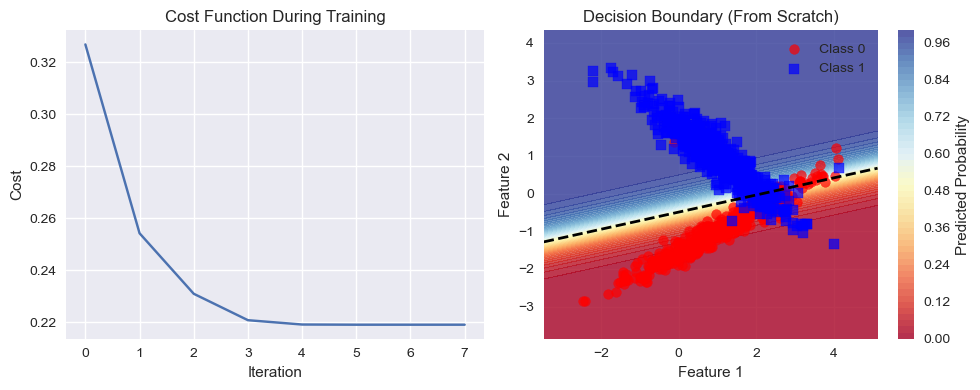

In [18]:
# Plot cost function during training
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(model_scratch.cost_history)
plt.title('Cost Function During Training')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.grid(True)

# Plot decision boundary
plt.subplot(1, 2, 2)

# Create a mesh for decision boundary
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Add bias term to mesh
mesh_points = np.c_[np.ones(xx.ravel().shape[0]), xx.ravel(), yy.ravel()]
Z = model_scratch.predict_proba(mesh_points)
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, levels=50, alpha=0.8, cmap='RdYlBu')
plt.colorbar(label='Predicted Probability')
plt.contour(xx, yy, Z, levels=[0.5], colors='black', linestyles='--', linewidths=2)

# Plot data points
plt.scatter(X[y==0, 0], X[y==0, 1], c='red', marker='o', alpha=0.7, label='Class 0')
plt.scatter(X[y==1, 0], X[y==1, 1], c='blue', marker='s', alpha=0.7, label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundary (From Scratch)')
plt.legend()

plt.tight_layout()
plt.show()

## Part 2: Exploring sklearn's LogisticRegression

Now let's compare our implementation with sklearn's and explore different parameters.

In [19]:
# Compare with sklearn's implementation
model_sklearn = LogisticRegression(random_state=42)
model_sklearn.fit(X_train[:, 1:], y_train)  # Remove bias term for sklearn

y_pred_sklearn = model_sklearn.predict(X_test[:, 1:])
accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)

print(f"Accuracy (sklearn): {accuracy_sklearn:.4f}")
print(f"Accuracy (from scratch): {accuracy_scratch:.4f}")
print(f"\nCoefficients comparison:")
print(f"From scratch (w/ bias): {model_scratch.theta}")
print(f"Sklearn weights: {model_sklearn.coef_[0]}")
print(f"Sklearn bias: {model_sklearn.intercept_[0]}")

Accuracy (sklearn): 0.8833
Accuracy (from scratch): 0.8833

Coefficients comparison:
From scratch (w/ bias): [ 1.94231775 -0.8970037   3.94592673]
Sklearn weights: [-0.72336264  3.54855707]
Sklearn bias: 1.529951129502809


### Exploring Different Regularization Strengths (C parameter)
The C parameter controls regularization strength. Smaller C = stronger regularization.

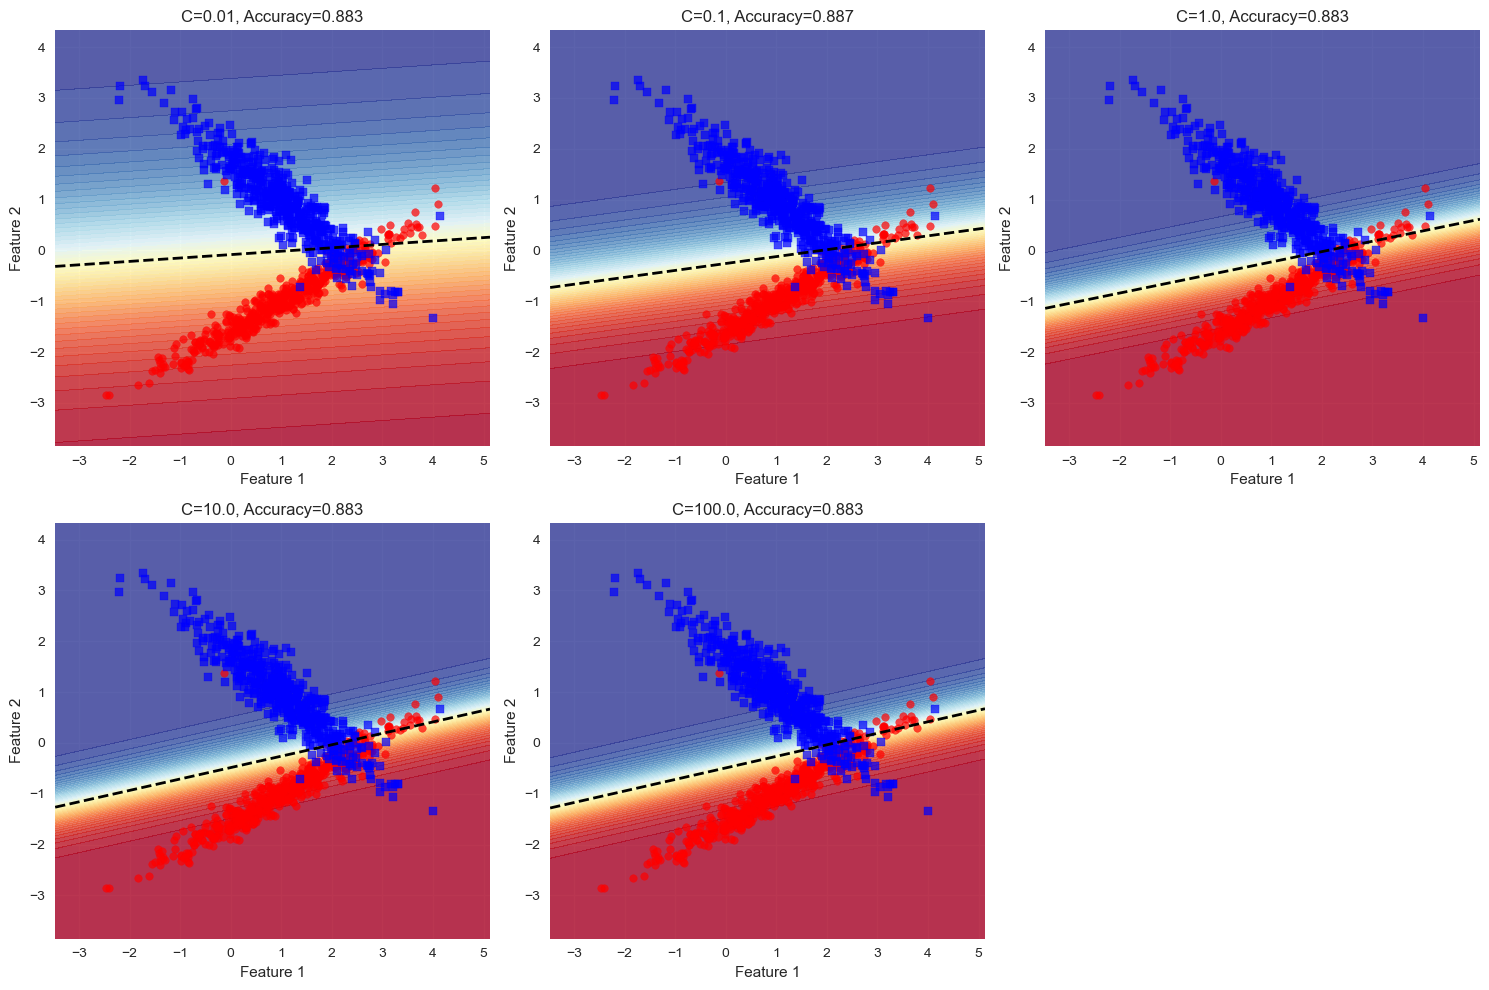

In [20]:
# TODO: Experiment with different C values
C_values = [0.01, 0.1, 1.0, 10.0, 100.0]

plt.figure(figsize=(15, 10))

for i, C in enumerate(C_values):
    # Train model with different C
    model = LogisticRegression(C=C, random_state=42)
    model.fit(X_train[:, 1:], y_train)
    
    # Calculate accuracy
    y_pred = model.predict(X_test[:, 1:])
    accuracy = accuracy_score(y_test, y_pred)
    
    # Plot decision boundary
    plt.subplot(2, 3, i+1)
    
    # Create mesh for visualization
    Z_sklearn = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z_sklearn = Z_sklearn.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z_sklearn, levels=50, alpha=0.8, cmap='RdYlBu')
    plt.contour(xx, yy, Z_sklearn, levels=[0.5], colors='black', linestyles='--', linewidths=2)
    
    plt.scatter(X[y==0, 0], X[y==0, 1], c='red', marker='o', alpha=0.7, s=30)
    plt.scatter(X[y==1, 0], X[y==1, 1], c='blue', marker='s', alpha=0.7, s=30)
    
    plt.title(f'C={C}, Accuracy={accuracy:.3f}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()

### Exploring Different Solvers
sklearn offers different optimization algorithms.

In [ ]:
# TODO: Compare different solvers
solvers = ['liblinear', 'lbfgs', 'newton-cg', 'sag']
solver_results = {}

for solver in solvers:
    try:
        model = LogisticRegression(solver=solver, random_state=42, max_iter=1000)
        model.fit(X_train[:, 1:], y_train)
        
        y_pred = model.predict(X_test[:, 1:])
        accuracy = accuracy_score(y_test, y_pred)
        
        solver_results[solver] = {
            'accuracy': accuracy,
            'n_iter': model.n_iter_[0] if hasattr(model, 'n_iter_') else 'N/A',
            'coef': model.coef_[0],
            'intercept': model.intercept_[0]
        }
        
    except Exception as e:
        print(f"Error with solver {solver}: {e}")

# Display results
print("Solver Comparison:")
print("-" * 60)
for solver, results in solver_results.items():
    print(f"{solver:12} | Accuracy: {results['accuracy']:.4f} | Iterations: {results['n_iter']}")
    print(f"             | Coefficients: {results['coef']}")
    print(f"             | Intercept: {results['intercept']:.4f}")
    print("-" * 60)

### Regularization Types: L1 vs L2
Compare Ridge (L2) vs Lasso (L1) regularization effects.

In [ ]:
# TODO: Compare L1 and L2 regularization
penalties = ['l1', 'l2']
C_values = [0.1, 1.0, 10.0]

plt.figure(figsize=(12, 8))

plot_idx = 1
for penalty in penalties:
    for C in C_values:
        # Use liblinear for L1, lbfgs for L2
        solver = 'liblinear' if penalty == 'l1' else 'lbfgs'
        
        model = LogisticRegression(C=C, penalty=penalty, solver=solver, random_state=42)
        model.fit(X_train[:, 1:], y_train)
        
        y_pred = model.predict(X_test[:, 1:])
        accuracy = accuracy_score(y_test, y_pred)
        
        plt.subplot(2, 3, plot_idx)
        
        # Decision boundary
        Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z = Z.reshape(xx.shape)
        
        plt.contourf(xx, yy, Z, levels=50, alpha=0.8, cmap='RdYlBu')
        plt.contour(xx, yy, Z, levels=[0.5], colors='black', linestyles='--', linewidths=2)
        
        plt.scatter(X[y==0, 0], X[y==0, 1], c='red', marker='o', alpha=0.7, s=20)
        plt.scatter(X[y==1, 0], X[y==1, 1], c='blue', marker='s', alpha=0.7, s=20)
        
        plt.title(f'{penalty.upper()}, C={C}\nAcc={accuracy:.3f}')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        
        # Print coefficient magnitudes
        coef_norm = np.linalg.norm(model.coef_[0])
        print(f"{penalty.upper()}, C={C}: Coefficient norm = {coef_norm:.4f}, Accuracy = {accuracy:.4f}")
        
        plot_idx += 1

plt.tight_layout()
plt.show()

### Model Performance Analysis

In [ ]:
# Final comparison and confusion matrices
models = {
    'From Scratch': (model_scratch.predict(X_test), 'From scratch implementation'),
    'sklearn Default': (model_sklearn.predict(X_test[:, 1:]), 'sklearn with default parameters'),
    'sklearn L1 (C=1)': (LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42)
                        .fit(X_train[:, 1:], y_train).predict(X_test[:, 1:]), 'sklearn with L1 regularization'),
    'sklearn L2 (C=0.1)': (LogisticRegression(penalty='l2', C=0.1, random_state=42)
                          .fit(X_train[:, 1:], y_train).predict(X_test[:, 1:]), 'sklearn with strong L2 regularization')
}

plt.figure(figsize=(16, 4))

for i, (name, (predictions, description)) in enumerate(models.items()):
    accuracy = accuracy_score(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)
    
    plt.subplot(1, 4, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{name}\nAccuracy: {accuracy:.4f}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

## Exercises for Students


1. **Modify the sigmoid function**: What happens if you change the sigmoid to other activation functions like tanh?

2. **Feature scaling**: Try the same experiments with and without feature scaling. How does it affect convergence?

3. **Different datasets**: Test your implementation on the iris dataset from sklearn.

4. **Learning curves**: Plot training and validation accuracy vs training set size to understand overfitting.

5. **Multiclass extension**: Extend your implementation to handle multiclass classification (one-vs-rest).